In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"


# New Section

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving server_logs_sample.csv to server_logs_sample.csv
Saving network_logs_sample.csv to network_logs_sample.csv
Saving mft_logs_sample.csv to mft_logs_sample.csv


In [ ]:
import pandas as pd

# Load each dataset
mft_logs = pd.read_csv('mft_logs_sample.csv')
server_logs = pd.read_csv('server_logs_sample.csv')
network_logs = pd.read_csv('network_logs_sample.csv')

# Preview data
print("MFT Logs Sample:")
print(mft_logs.head())

print("\nServer Logs Sample:")
print(server_logs.head())

print("\nNetwork Logs Sample:")
print(network_logs.head())


MFT Logs Sample:
                    timestamp  file_size_MB  transfer_time_sec user_id  \
0  2025-04-30 20:43:12.244841         23.46               0.16  user_1   
1  2025-04-30 20:48:12.244841        150.51               5.06  user_1   
2  2025-04-30 20:53:12.244841         65.84               1.89  user_3   
3  2025-04-30 20:58:12.244841         45.65               3.55  user_2   
4  2025-04-30 21:03:12.244841          8.48              11.91  user_2   

         dest_ip  
0   192.168.1.64  
1  192.168.1.191  
2  192.168.1.144  
3  192.168.1.138  
4   192.168.1.68  

Server Logs Sample:
                    timestamp  cpu_usage_percent  memory_usage_percent  \
0  2025-04-30 20:43:12.244841              43.08                 84.66   
1  2025-04-30 20:48:12.244841              10.92                 79.35   
2  2025-04-30 20:53:12.244841              86.96                 86.99   
3  2025-04-30 20:58:12.244841              17.76                 73.54   
4  2025-04-30 21:03:12.244841    

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Standardize column names
mft_logs.columns = mft_logs.columns.str.strip().str.lower()
server_logs.columns = server_logs.columns.str.strip().str.lower()
network_logs.columns = network_logs.columns.str.strip().str.lower()

# Convert timestamps
mft_logs['timestamp'] = pd.to_datetime(mft_logs['timestamp'])
server_logs['timestamp'] = pd.to_datetime(server_logs['timestamp'])
network_logs['timestamp'] = pd.to_datetime(network_logs['timestamp'])

# Add hour feature
mft_logs['hour_of_day'] = mft_logs['timestamp'].dt.hour
server_logs['hour_of_day'] = server_logs['timestamp'].dt.hour

# Unique dest IPs per user
mft_logs['unique_dest_ips'] = mft_logs.groupby('user_id')['dest_ip'].transform('nunique')

# Encode user_id
le = LabelEncoder()
mft_logs['user_id_encoded'] = le.fit_transform(mft_logs['user_id'])

# Server logs aggregation
server_agg = server_logs.groupby('user_id').agg({
    'cpu_usage_percent': 'mean',
    'memory_usage_percent': 'mean',
    'failed_logins': 'sum'
}).reset_index()
server_agg.rename(columns={
    'cpu_usage_percent': 'cpu_usage',
    'memory_usage_percent': 'memory_usage'
}, inplace=True)

# Simulate user_id for network logs using src_ip → user_id mapping from mft_logs
ip_user_map = mft_logs[['user_id', 'dest_ip']].drop_duplicates()
network_logs = network_logs.merge(ip_user_map, left_on='src_ip', right_on='dest_ip', how='left')

# Aggregate network logs
network_agg = network_logs.groupby('user_id').agg({
    'bytes_sent': 'mean',
    'bytes_received': 'mean'
}).reset_index()
network_agg.rename(columns={
    'bytes_sent': 'data_out_mb',
    'bytes_received': 'data_in_mb'
}, inplace=True)

# Merge all
merged_df = mft_logs.merge(server_agg, on='user_id', how='left')
merged_df = merged_df.merge(network_agg, on='user_id', how='left')
merged_df.fillna(0, inplace=True)

# Normalize
scaler = MinMaxScaler()
fields_to_normalize = [
    'file_size_mb', 'transfer_time_sec', 'unique_dest_ips', 'hour_of_day',
    'cpu_usage', 'memory_usage', 'failed_logins',
    'data_in_mb', 'data_out_mb'
]
merged_df[fields_to_normalize] = scaler.fit_transform(merged_df[fields_to_normalize])

# Final output
final_df = merged_df[fields_to_normalize + ['user_id_encoded']]
final_df.to_csv('sample_mft_logs_normalized.csv', index=False)

print("✅ Final normalized dataset saved as sample_mft_logs_normalized.csv")
final_df.head()


✅ Final normalized dataset saved as sample_mft_logs_normalized.csv


file_size_mb  transfer_time_sec  unique_dest_ips  hour_of_day  cpu_usage  \
0      0.107102           0.006135            1.000     0.869565   1.000000   
1      0.694127           0.237376            1.000     0.869565   1.000000   
2      0.302915           0.087777            0.875     0.869565   0.231346   
3      0.209629           0.166116            1.000     0.869565   0.000000   
4      0.037888           0.560642            1.000     0.913043   0.000000   

   memory_usage  failed_logins  data_in_mb  data_out_mb  user_id_encoded  
0      0.250629       1.000000         0.0          0.0                0  
1      0.250629       1.000000         0.0          0.0                0  
2      0.725873       0.785714         0.0          0.0                2  
3      0.000000       0.928571         0.0          0.0                1  
4      0.000000       0.928571         0.0          0.0                1

In [ ]:
import pandas as pd

# Load normalized data
data = pd.read_csv("sample_mft_logs_normalized.csv")




In [ ]:
from sklearn.ensemble import IsolationForest

# Define the features (exclude any post-processing or label columns)
feature_columns = [col for col in data.columns if col not in ['anomaly_score', 'anomaly']]

# Initialize and train the model using only original features
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(data[feature_columns])

# Predict anomalies
data['anomaly_score'] = model.decision_function(data[feature_columns])
data['anomaly'] = model.predict(data[feature_columns])  # -1 = anomaly, 1 = normal

# Convert to 1 = anomaly, 0 = normal
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})



In [ ]:
data.to_csv("mft_logs_with_anomalies.csv", index=False)
print("✅ Saved: mft_logs_with_anomalies.csv")


✅ Saved: mft_logs_with_anomalies.csv


In [ ]:
from google.colab import files
files.download("mft_logs_with_anomalies.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

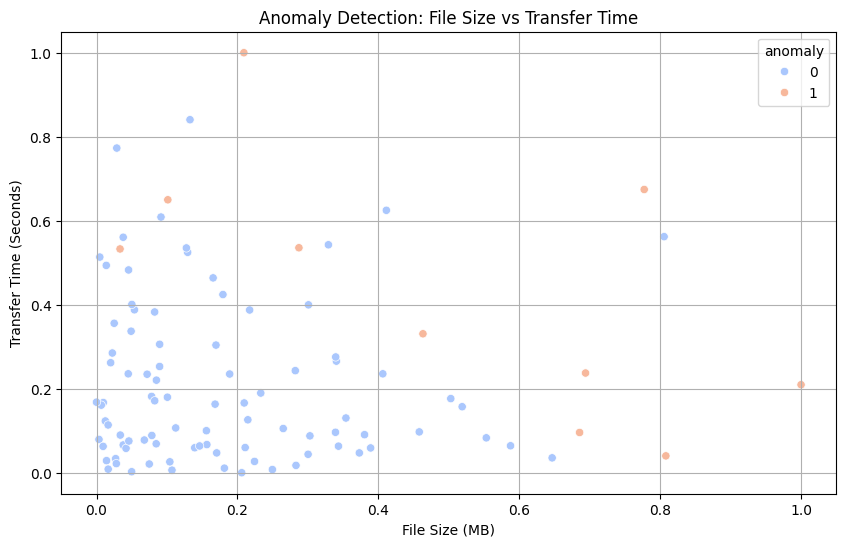

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct column name: 'file_size_mb'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='file_size_mb', y='transfer_time_sec', hue='anomaly', palette='coolwarm')
plt.title('Anomaly Detection: File Size vs Transfer Time')
plt.xlabel('File Size (MB)')
plt.ylabel('Transfer Time (Seconds)')
plt.grid(True)
plt.show()



In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [2]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 939.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


2025-05-15 01:45:49.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:45:49.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:45:49.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-05-15 01:46:43.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.222 Session state does not function when running a script without `streamlit run`
2025-05-15 01:46:43.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46

Saving mft_logs_with_anomalies.csv to mft_logs_with_anomalies.csv


2025-05-15 01:46:43.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.660 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.716 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 01:46:43.890 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

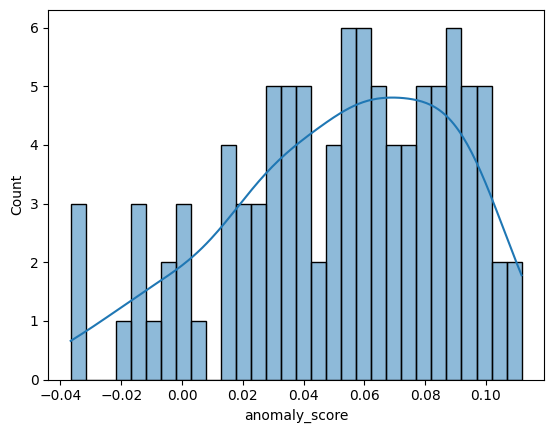

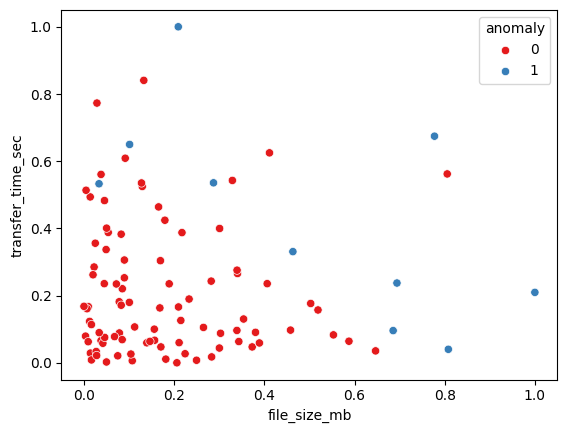

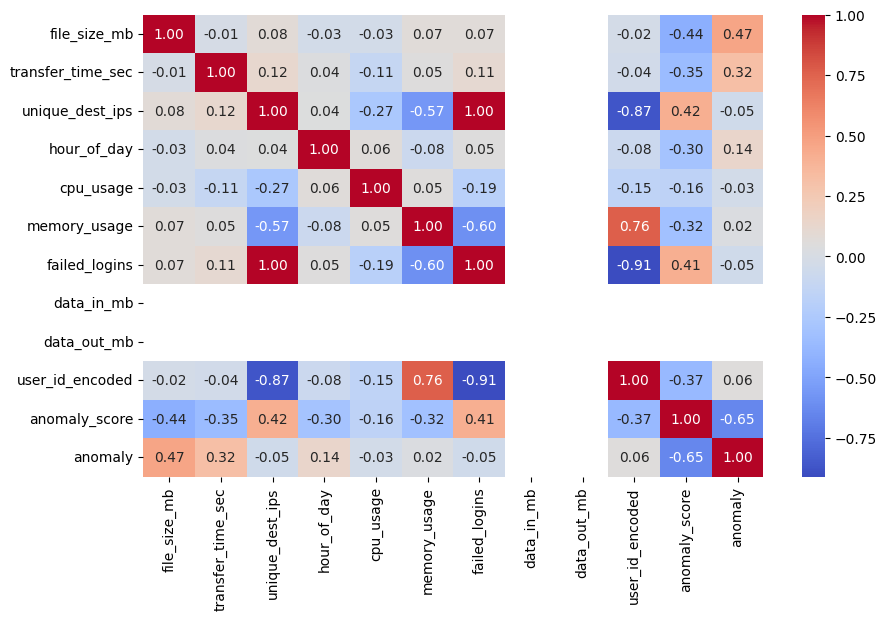

In [8]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(layout="wide")
st.title("📊 MFT Anomaly Detection Dashboard")

# Load data
from google.colab import files
uploaded = files.upload()
data = pd.read_csv("mft_logs_with_anomalies.csv")

# Sidebar filters
st.sidebar.header("Filter Data")
anomaly_filter = st.sidebar.selectbox("Filter by Anomaly", ["All", "Normal (1)", "Anomaly (-1)"])

if anomaly_filter == "Normal (1)":
    data = data[data["anomaly"] == 1]
elif anomaly_filter == "Anomaly (-1)":
    data = data[data["anomaly"] == -1]

# KPI cards
col1, col2, col3 = st.columns(3)
col1.metric("Total Records", len(data))
col2.metric("Anomalies", len(data[data["anomaly"] == -1]))
col3.metric("Normal", len(data[data["anomaly"] == 1]))

# Anomaly score distribution
st.subheader("📉 Anomaly Score Distribution")
fig1, ax1 = plt.subplots()
sns.histplot(data['anomaly_score'], bins=30, kde=True, ax=ax1)
st.pyplot(fig1)

# File Size vs Transfer Time Scatter
st.subheader("📌 File Size vs Transfer Time")
fig2, ax2 = plt.subplots()
sns.scatterplot(data=data, x='file_size_mb', y='transfer_time_sec', hue='anomaly', palette='Set1', ax=ax2)
st.pyplot(fig2)

# Heatmap of all features
st.subheader("🔥 Feature Correlation Heatmap")
fig3, ax3 = plt.subplots(figsize=(10, 6))
sns.heatmap(data.corr(), cmap="coolwarm", annot=True, fmt=".2f", ax=ax3)
st.pyplot(fig3)

# Top Users with Anomalies
st.subheader("👤 Top Users with Anomalies")
top_users = data[data["anomaly"] == -1]["user_id_encoded"].value_counts().head(10)
st.bar_chart(top_users)


In [ ]:
streamlit run mft_anomaly_dashboard.py


SyntaxError: invalid syntax (<ipython-input-17-1994080d8e94>, line 1)